## DDA3020 Autumn 2023 Homework 3 

### Programming Part 2：Neural Networks with PyTorch

--------------------------------------------------------------------------------------------------------------------------
In this notebook, we will build a fully-connected Neural Network and a Convolutional Neural Network with PyTorch, then apply on the MNIST data-set.

--------------------------------------------------------------------------------------------------------------------------


In [1]:
import numpy as np
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)

### 1. Preparation: PyTorch basics and back-propagation (10 points)
PyTorch is one of the most popular frameworks for Deep Learning. To have a quick insight on how to use PyTorch, let's say that most of the functionalities of a numpy array are also maintained for torch tensors, except that the grammar might be slightly different. 

##### 1-1 (0.5 point) 

Set the random seed to 123. Create a random Tensor `a` of shape [3,20,20] with default normal distribution $\mathcal{N}(0,1)$. 

In [2]:
torch.manual_seed(123)
a = torch.randn((3, 20, 20))

##### 1-2 (0.5 point) 
1. Transfer `a` to a numpy array and print `a[0,0]`.
2. Transfer `a` back to torch tensor and print `a[0,0]`.

**Apart from this block, in this section, you shall not to use numpy**



In [3]:
a = a.numpy()
print(a[0, 0])
a = torch.from_numpy(a)
print(a[0, 0])

[ 0.3374 -0.1778 -0.3035 -0.588   0.3486  0.6603 -0.2196 -0.3792  0.7671
 -1.1925  0.6984 -1.4097  0.1794  1.8951  0.4954  0.2692 -0.077  -1.0205
 -0.169   0.9178]
tensor([ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
         0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692,
        -0.0770, -1.0205, -0.1690,  0.9178])


##### 1-3 (1 point) 

Print for `a`: 
- its shape (size)
- its mean value over all entries
- its std over all entries
- its median value over all entries

In [4]:
print(f"shape: {a.shape}")
print(f"mean: {a.mean().item():.4f}")
print(f"std: {a.std().item():.4f}")
print(f"median: {a.median().item():.4f}")

shape: torch.Size([3, 20, 20])
mean: -0.0028
std: 0.9965
median: -0.0016


##### 1-4 (1 point)

Compute: 
- `b2` = the mean values of `a` along axis 2
- `b12`= the mean values of `a` along axis 1 and 2
- Print the shape of `b2` and `b12`

In [5]:
b2 = a.mean(axis=2)
b12 = a.mean(axis=(1, 2))
print(f"b2 shape: {b2.shape}")
print(f"b12 shape: {b12.shape}")

b2 shape: torch.Size([3, 20])
b12 shape: torch.Size([3])


##### 1-5 (3 point) 

Set the random seed to 123. Create a neural network `model_tmp` of 3 layers:

- layer 1 ---------- : receives input of length 400, has 128 neurons with bias

- activation 1 ----- : relu

- layer 2 ---------- : receives input of length 128, has 64 neurons with bias

- activation 2 ----- : relu

- layer 3 ---------- : receives input of length 64, has 4 neurons without bias

- activation 3 ----- : softmax over axis -1

[Hint]: you will mainly use modules from torch.nn



In [6]:
import torch.nn as nn
torch.manual_seed(123)

model_tmp = nn.Sequential(
	nn.Linear(400, 128, bias=True),
	nn.ReLU(),
	nn.Linear(128, 64, bias=True),
	nn.ReLU(),
	nn.Linear(64, 4, bias=False),
	nn.Softmax(dim=-1)
)

##### 1-6 (1 point) 

Flatten the two last axis of `a` and apply `model_tmp` on `a`. Print your output.

`[Verify]`: Your output should be $$[[0.2528, 0.2571, 0.2370, 0.2530],\\
        [0.2508, 0.2230, 0.2388, 0.2874],\\
        [0.2643, 0.2372, 0.2225, 0.2761]]$$

In [7]:
y_pred = model_tmp(a.reshape(3, -1))
print(y_pred)

tensor([[0.2528, 0.2571, 0.2370, 0.2530],
        [0.2508, 0.2230, 0.2388, 0.2874],
        [0.2643, 0.2372, 0.2225, 0.2761]], grad_fn=<SoftmaxBackward0>)


##### 1-7 (1 point) 
Calculate the MSE loss between `this output` and an `all-1 tensor`. Print your result.

`[Verify]`: Your output should be 0.5629

[Hint]: You can use either **torch.nn.functional** or **torch.nn** or **torch**


In [8]:
import torch.nn.functional as F

y_true = torch.ones_like(y_pred)
loss = F.mse_loss(y_pred, y_true)
print(loss)

tensor(0.5629, grad_fn=<MseLossBackward0>)


##### 1-8 (1 point) 
Excecute `back-propagation` on this loss and extract the gradient of the `final layer` of model_tmp as `grd`. Print `grd[:,5]`

`[Verify]`: You should see $$[ 7.4889 e^{-5}, -2.6256e^{-5}, -3.4365e^{-4},  2.9502 e^{-4}]$$

[Hint]: To extract the weights, you can use w_last_layer = list(model.parameters())[-1] or any other more elegant phrase.

In [9]:
loss.backward()
grd = model_tmp[-2].weight.grad
print(grd[:, 5])

tensor([ 7.4889e-05, -2.6256e-05, -3.4365e-04,  2.9502e-04])


##### 1-9 (1 point) 
1. Create a `SGD optimizer` with learning_rate = `1e-3` associated with the parameters of model_tmp. 
2. Step this optimizer. 
3. Verify that the `variation of the parameters` of the last layer equals `1e-3 * grd`, except that there might be some machine inaccuracies.

[Hint]: You can simple print something and we'll see that most of the entries are near 0 or that most of the entries are near 0.001

In [10]:
optimizer = torch.optim.SGD(model_tmp.parameters(), lr=1e-3)
w_ = model_tmp[-2].weight - 1e-3 * model_tmp[-2].weight.grad
optimizer.step()
w = model_tmp[-2].weight
print(w - w_)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.

### 2. Simple fully-connected NN (MLP) (12 points)

**`Procedure`**: (1+1+1+1 = 4 points)
1. Create a fully-connected neural network, which will be a MLP. This NN will take the fattened images ([28,28] -> [28*28]) as input.  
2. Choose your optimizer and criterion (loss function).
3. Train some epoches (you can start with 10) on the MNIST data-set.
4. Keep your best model according to validation loss.
5. `Save your best model and attach it in your submitted zip`.

**`Required outputs`**: (1+1+2 = 4 points)
1. Print averaged train loss and validation loss at the end of each epoch.
2. After the training finished, plot your train (validation, respectively) loss of each step (epoch, respectively) on a same graph. Keep the x-axis aligned.
3. Test your best model on test set and print (1) test loss value as well as (2) the rate of correct prediction. 


4 points are given according to your test performance. `4 is given if you have correct test prediction rate > 90.00%`



In [11]:
#### prepare data-set
#### you re expected to have either pickle or torchvision in your environment

import torch
from torch.utils.data import DataLoader, Dataset, Subset
import importlib

# python > 3.4
if importlib.util.find_spec('torchvision') is None: # if you do not have torchvision, use TA's downloaded data
    import pickle as pkl

    with open('./MNIST_dataset_local','rb') as read_file:
        data = pkl.load(read_file)
        read_file.close()

    train_images, train_labels = data['train']
    test_images, test_labels = data['test']

    val_images, val_labels = train_images[5500:], train_labels[5500:]
    train_images, train_labels = train_images[:5500], train_labels[:5500]

    class myMnistDataSet(Dataset):

        def __init__(self,images,labels):
            self.X = images[:,None,...]
            self.y = labels

        def __len__(self):
            return len(self.X)

        def __getitem__(self, index):
            image = self.X[index]
            label = self.y[index]
            return torch.Tensor(image), torch.tensor(label)[0]
        
    mnist_train = myMnistDataSet(train_images, train_labels.astype('int64'))
    mnist_test = myMnistDataSet(test_images, test_labels.astype('int64'))
    mnist_val = myMnistDataSet(val_images, val_labels.astype('int64'))

else: # use torchvision
    from torchvision import transforms, datasets

    mnist_download_path = './MNIST_dataset'
    datasets.MNIST(root=mnist_download_path, download=True)

    mnist_train = datasets.MNIST(root = mnist_download_path, train = True, transform=transforms.ToTensor())
    mnist_val   = Subset(mnist_train, list(range(5500,6000)))
    mnist_train = Subset(mnist_train, list(range(5500)))

    mnist_test  = datasets.MNIST(root = mnist_download_path, train = False, transform=transforms.ToTensor())


def get_loaders(batch_size):
    train_loader = DataLoader(mnist_train, batch_size = batch_size, shuffle=True)
    val_loader   = DataLoader(mnist_val, batch_size = batch_size, shuffle=False)
    test_loader  = DataLoader(mnist_test, batch_size = batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# get to know your loader
batch_size = 32
train_loader, val_loader, test_loader = get_loaders(batch_size)

for im, l in val_loader:
    break

print(im.shape, l.shape)
print(l)

torch.Size([32, 1, 28, 28]) torch.Size([32])
tensor([1, 9, 0, 9, 7, 0, 5, 1, 2, 2, 3, 3, 0, 4, 0, 5, 1, 6, 9, 7, 1, 8, 9, 9,
        6, 0, 5, 1, 2, 2, 1, 3])


Number of parameters: 235146
Epoch 1/10 | Train loss: 1.8578 | Val loss: 1.6225
Epoch 2/10 | Train loss: 1.5900 | Val loss: 1.5711
Epoch 3/10 | Train loss: 1.5587 | Val loss: 1.5497
Epoch 4/10 | Train loss: 1.5402 | Val loss: 1.5453
Epoch 5/10 | Train loss: 1.5307 | Val loss: 1.5415
Epoch 6/10 | Train loss: 1.5225 | Val loss: 1.5410
Epoch 7/10 | Train loss: 1.5158 | Val loss: 1.5498
Epoch 8/10 | Train loss: 1.5114 | Val loss: 1.5518
Epoch 9/10 | Train loss: 1.5083 | Val loss: 1.5350
Epoch 10/10 | Train loss: 1.5032 | Val loss: 1.5368


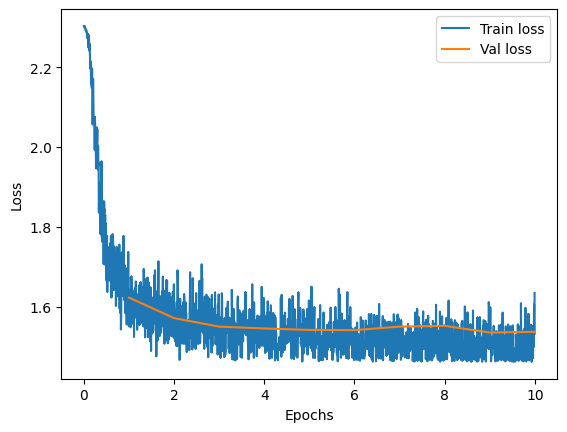

In [12]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

model = nn.Sequential(
	nn.Flatten(),
	nn.Linear(784, 256),
	nn.ReLU(),
	nn.Linear(256, 128),
	nn.ReLU(),
	nn.Linear(128, 10),
	nn.Softmax(dim=-1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss().to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

EPOCHS = 10
losses_train = []
losses_val = []
best_loss = 1e9
best_model = None
for epoch in range(EPOCHS):
	losses = []
	for X, y in train_loader:
		X, y = X.to(device), y.to(device)
		optimizer.zero_grad()
		y_pred = model(X)
		loss = criterion(y_pred, y)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
	losses_train.extend(losses)
	print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {np.mean(losses):.4f}", end=' | ')
	losses = []
	with torch.no_grad():
		for X, y in val_loader:
			X, y = X.to(device), y.to(device)
			y_pred = model(X)
			loss = criterion(y_pred, y)
			losses.append(loss.item())
	losses_val.append(np.mean(losses).item())
	print(f"Val loss: {losses_val[-1]:.4f}")
	if losses_val[-1] < best_loss:
		best_loss = losses_val[-1]
		best_model = model.state_dict()

# torch.save(best_model, './best_model_nn.pt')
# model.load_state_dict(torch.load('./best_model_nn.pt'))

import matplotlib.pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(0, EPOCHS, EPOCHS/len(losses_train)), losses_train, label='Train loss')
plt.plot(np.arange(1, EPOCHS+1), losses_val, label='Val loss')
plt.legend()
plt.show()

In [13]:
with torch.no_grad():
	losses = []
	accuracy = []
	for X, y in test_loader:
		X, y = X.to(device), y.to(device)
		y_pred = model(X)
		loss = criterion(y_pred, y)
		losses.append(loss.item())
		accuracy.extend((y_pred.argmax(dim=-1) == y).float().tolist())
	print(f"Test loss: {np.mean(losses):.4f} | Test accuracy: {np.mean(accuracy)*100:.2f}%")

Test loss: 1.5453 | Test accuracy: 92.05%


### 3. Bonus - Weight game (Bonus 2+4+1 = 7 points. Bonus is for this exercise exclusively)

3-1. Display
- The average image of respectively label 1-10 over the validation set.

3-2. Build a 1-layer NN for this problem. Use `Binary Cross Entropy Loss` as validation criterion. Train some epoches until `validation loss < 0.1`. This 1-layer NN has no more than 2 parameters (w and b). Display w with respect to label 1-10, for:

 - Before training (randomly initialized weights). Print the validation loss at this moment.
 - After val loss < 0.1 

3-3. Use **`one word`** to summarize the mecanism with which this NN works.

[Hint]: 
 - For display, please refer to solution_HW1_polynomial_regression for loop structure. This time you will use plt.imshow()  
 - The weight shape is [10,28*28]. Reshape to [10,28,28] then plot 10 times [28,28]

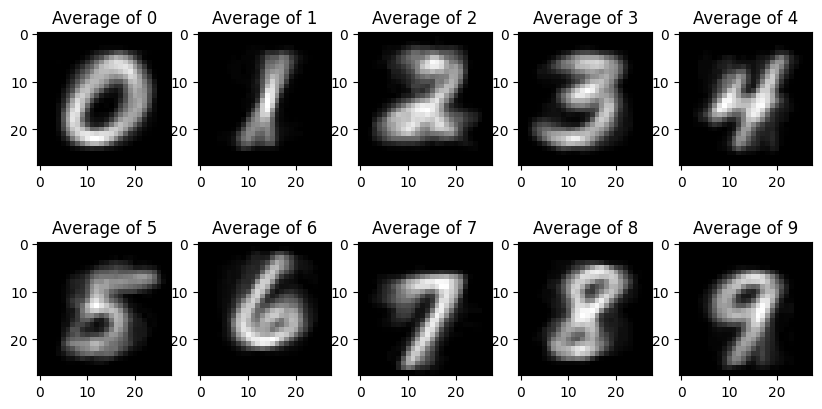

In [14]:
avg = np.zeros((10, 28, 28))
cnt = np.zeros(10)
for X, y in val_loader:
	for _ in range(X.shape[0]):
		avg[y[_]] += X[_, 0].numpy()
		cnt[y[_]] += 1
avg /= cnt[:, None, None]

plt.subplots(2, 5, figsize=(10, 5))
for i in range(10):
	plt.subplot(2, 5, i+1)
	plt.imshow(avg[i], cmap='gray')
	plt.title(f"Average of {i}")
plt.show()

Training for 0
Loss before training: 0.7195 | Loss after training: 0.0839


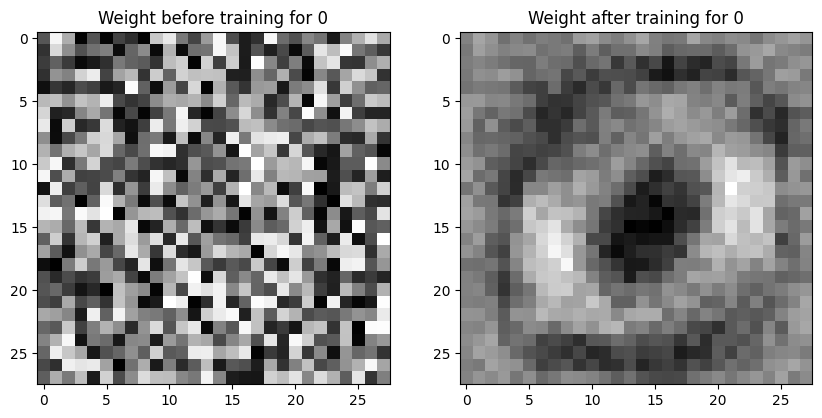

Training for 1
Loss before training: 0.6442 | Loss after training: 0.0954


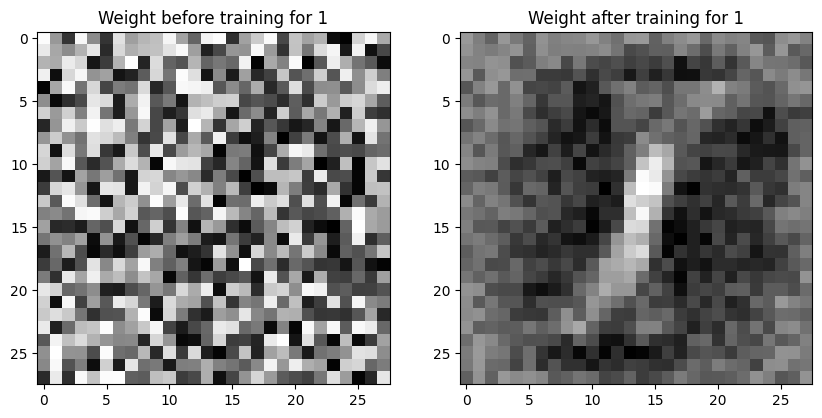

Training for 2
Loss before training: 0.7515 | Loss after training: 0.0992


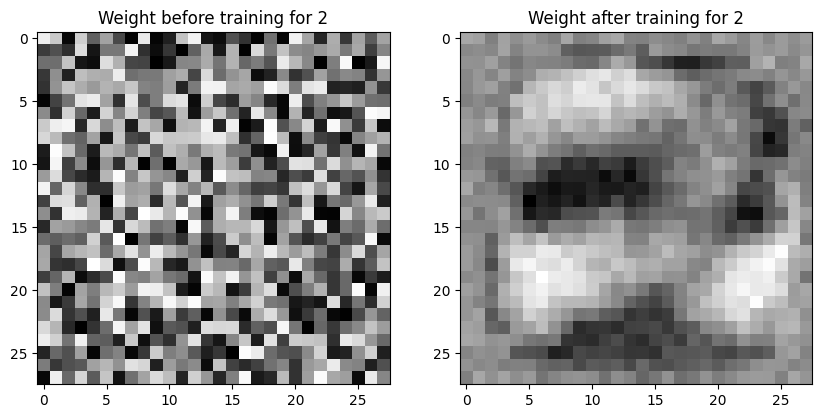

Training for 3
Loss before training: 0.7047 | Loss after training: 0.0986


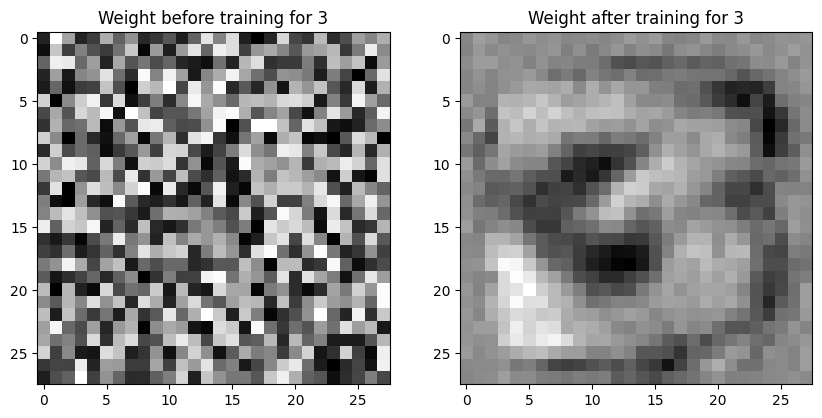

Training for 4
Loss before training: 0.6509 | Loss after training: 0.0917


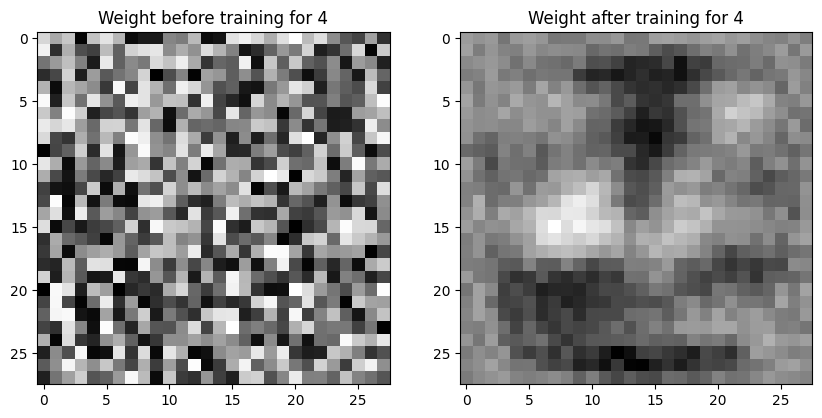

Training for 5
Loss before training: 0.7232 | Loss after training: 0.0998


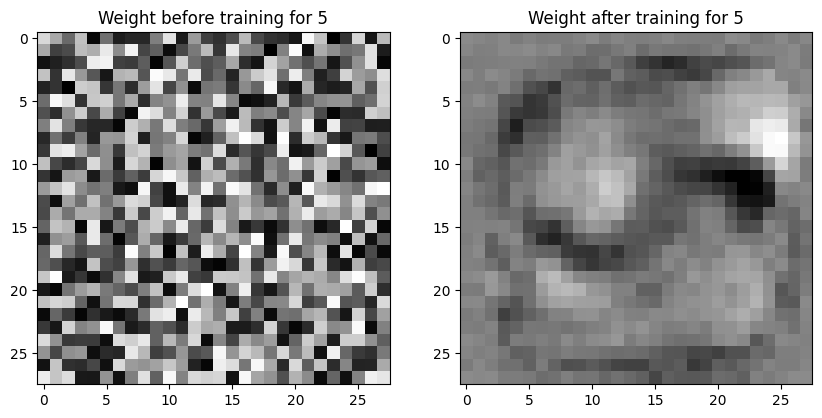

Training for 6
Loss before training: 0.6506 | Loss after training: 0.0961


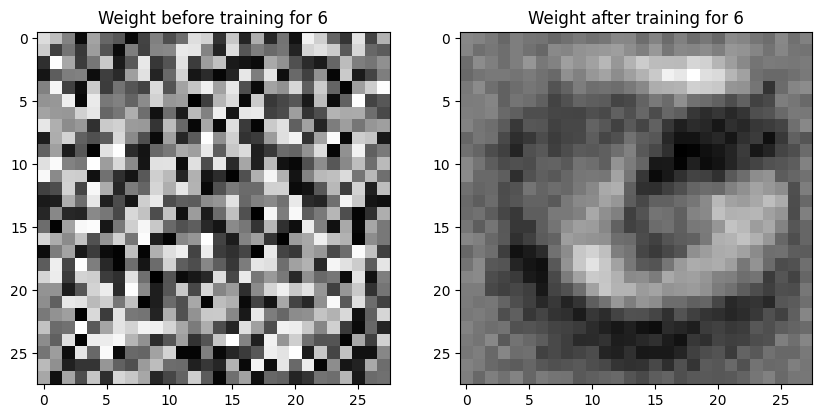

Training for 7
Loss before training: 0.7105 | Loss after training: 0.0962


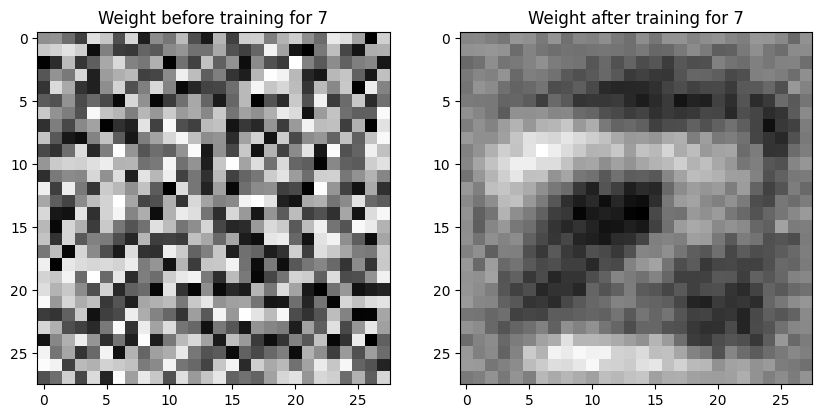

Training for 8
Loss before training: 0.7577 | Loss after training: 0.1364


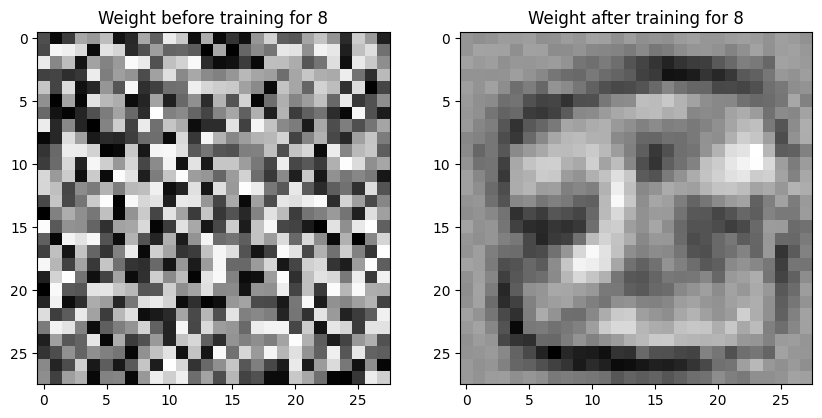

Training for 9
Loss before training: 0.7674 | Loss after training: 0.1248


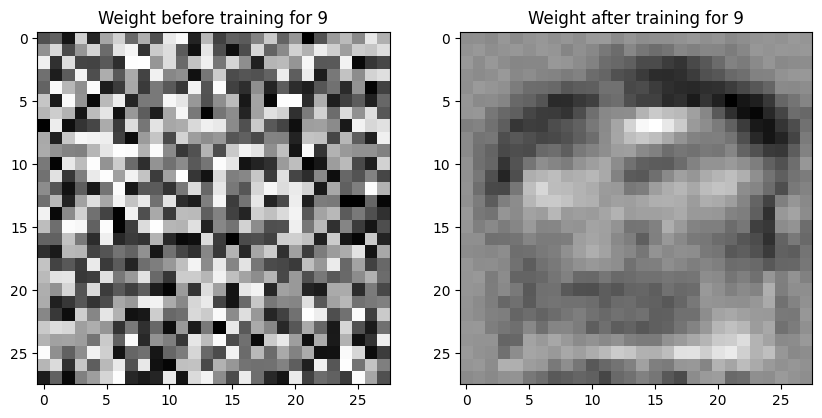

In [15]:
for cur in range(10):
	plt.subplots(1, 2, figsize=(10, 5))
	print(f"Training for {cur}")
	model = nn.Sequential(
		nn.Flatten(),
		nn.Linear(784, 1),
		nn.Sigmoid()
	).to(device)
	optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
	criterion = nn.BCELoss().to(device)

	losses = []
	with torch.no_grad():
		for X, y in val_loader:
			X, y = X.to(device), y.to(device).reshape(-1)
			y_pred = model(X)
			loss = criterion(y_pred, (y == cur).float().unsqueeze(-1))
			losses.append(loss.item())
	print(f"Loss before training: {np.mean(losses):.4f}", end=' | ')
	plt.subplot(1, 2, 1)
	plt.imshow(model[1].weight.cpu().detach().numpy().reshape(28, 28), cmap='gray')
	plt.title(f"Weight before training for {cur}")

	for _ in range(20):
		for X, y in train_loader:
			X, y = X.to(device), y.to(device).reshape(-1)
			optimizer.zero_grad()
			y_pred = model(X)
			loss = criterion(y_pred, (y == cur).float().unsqueeze(-1))
			loss.backward()
			optimizer.step()
		losses = []
		with torch.no_grad():
			for X, y in val_loader:
				X, y = X.to(device), y.to(device)
				y_pred = model(X)
				loss = criterion(y_pred, (y == cur).float().unsqueeze(-1))
				losses.append(loss.item())
		if np.mean(losses) < 0.1:
			break
	
	print(f"Loss after training: {np.mean(losses):.4f}")
	plt.subplot(1, 2, 2)
	plt.imshow(model[1].weight.cpu().detach().numpy().reshape(28, 28), cmap='gray')
	plt.title(f"Weight after training for {cur}")
	plt.show()

**One word**: one-vs-all

### 4. CNN (13 points)

`Build your own CNN from scratch (3 points)` to solve this classification problem. Choose any optimizer and criterion that you want. Regulate your CNN structure and try to have as good result as possible.


**`Required outputs`**: (0.5+1+1+2+1 = 5.5 points)
1. Print the number of parameters of your cnn model.
2. Print averaged train loss and validation loss at the end of each epoch.
3. After the training finished, plot your train (validation, respectively) loss of each step (epoch, respectively) on a same graph. Keep the x-axis aligned.
4. Test your best model on test set and print (1) test loss value as well as (2) the rate of correct prediction. 
5. Display the confusion matrix of your best model on the test set.
6. `Save your best model and attach it in your submitted zip`.


4.5 points are given according to your test performance. `4.5 is given if you have correct test prediction rate > 97.00%.`

[Hint]: 
1. If you use batch normalizations, be aware of what BatchNorm does while fed with data (you will need to add two lines of codes to manage your training and testing).
1. As for confusion matrix (multi-class classfication), consider a $10\times 10$ matrix where each row represents "gt is" and each column represents "is predicted as", then do a counting with all the test samples. You will obtain a gray-scale image (2D matrix).





------------------------------------------------------------------------------------------------------------------------------------------------
`Discussion for computational cost`: 

If you have NVIDIA card on your PC, you can use `cuda` to accelerate the calculation. However, theoretically, `2 layers of CNN are enough` to have at least 97% test accuracy for this exercise. 

If your PC has no worse than Intel Core i5-8250U Processor (as had the TA's PC in 2019) and your code is well done, the program shall be guaranteed to run fast.

Conventionally, `you are encouraged to construct not too complicated CNN` to save computational cost, since MNIST is a relatively simple problem. However, `as long as your code works out for you, no point will be removed if your CNN is huge`.

------------------------------------------------------------------------------------------------------------------------------------------------


Number of parameters: 3431818
Epoch 1/12 | Train loss: 1.7795 | Val loss: 1.6019
Epoch 2/12 | Train loss: 1.6075 | Val loss: 1.6064
Epoch 3/12 | Train loss: 1.5953 | Val loss: 1.5721
Epoch 4/12 | Train loss: 1.5642 | Val loss: 1.5190
Epoch 5/12 | Train loss: 1.4868 | Val loss: 1.4979
Epoch 6/12 | Train loss: 1.4865 | Val loss: 1.5128
Epoch 7/12 | Train loss: 1.4794 | Val loss: 1.5097
Epoch 8/12 | Train loss: 1.4769 | Val loss: 1.5019
Epoch 9/12 | Train loss: 1.4724 | Val loss: 1.4932
Epoch 10/12 | Train loss: 1.4727 | Val loss: 1.4893
Epoch 11/12 | Train loss: 1.4708 | Val loss: 1.5067
Epoch 12/12 | Train loss: 1.4720 | Val loss: 1.4881


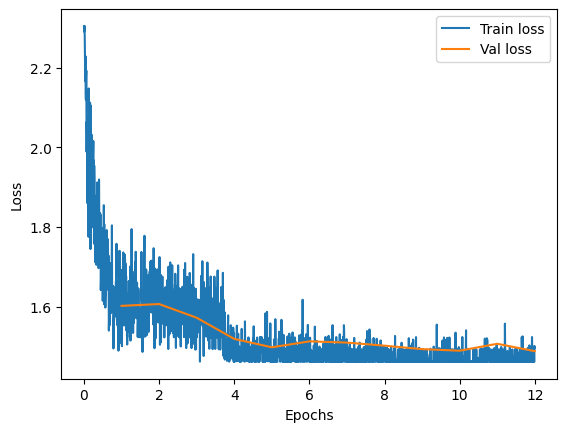

In [16]:
model = nn.Sequential(
	nn.Conv2d(1, 64, 5), # (1, 28, 28) -> (64, 24, 24)
	nn.ReLU(),
	nn.MaxPool2d(2), # (64, 24, 24) -> (64, 12, 12)
	nn.Conv2d(64, 256, 3), # (64, 12, 12) -> (256, 10, 10)
	nn.ReLU(),
	nn.MaxPool2d(2), # (256, 10, 10) -> (256, 5, 5)
	nn.Flatten(),
	nn.Linear(256*5*5, 512),
	nn.ReLU(),
	nn.Linear(512, 10),
	nn.Softmax(dim=-1)
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.CrossEntropyLoss().to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

EPOCHS = 12
losses_train = []
losses_val = []
best_loss = 1e9
best_model = None
for epoch in range(EPOCHS):
	losses = []
	for X, y in train_loader:
		X, y = X.to(device), y.to(device)
		optimizer.zero_grad()
		y_pred = model(X)
		loss = criterion(y_pred, y)
		losses.append(loss.item())
		loss.backward()
		optimizer.step()
	losses_train.extend(losses)
	print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {np.mean(losses):.4f}", end=' | ')
	losses = []
	with torch.no_grad():
		for X, y in val_loader:
			X, y = X.to(device), y.to(device)
			y_pred = model(X)
			loss = criterion(y_pred, y)
			losses.append(loss.item())
	losses_val.append(np.mean(losses).item())
	print(f"Val loss: {losses_val[-1]:.4f}")
	if losses_val[-1] < best_loss:
		best_loss = losses_val[-1]
		best_model = model.state_dict()

# torch.save(best_model, './best_model_cnn.pt')
# model.load_state_dict(torch.load('./best_model_cnn.pt'))

import matplotlib.pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(0, EPOCHS, EPOCHS/len(losses_train)), losses_train, label='Train loss')
plt.plot(np.arange(1, EPOCHS+1), losses_val, label='Val loss')
plt.legend()
plt.show()

Test loss: 1.4870 | Test accuracy: 97.43%


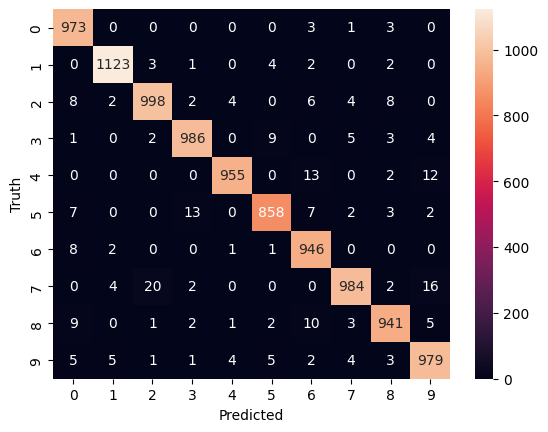

In [17]:
confusion = np.zeros((10, 10))
with torch.no_grad():
	losses = []
	accuracy = []
	for X, y in test_loader:
		X, y = X.to(device), y.to(device)
		y_pred = model(X)
		loss = criterion(y_pred, y)
		losses.append(loss.item())
		accuracy.extend((y_pred.argmax(dim=-1) == y).float().tolist())
		for i in range(X.shape[0]):
			confusion[y[i], y_pred.argmax(dim=-1)[i]] += 1
	print(f"Test loss: {np.mean(losses):.4f} | Test accuracy: {np.mean(accuracy)*100:.2f}%")

import seaborn as sns
sns.heatmap(confusion, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()